In [139]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [140]:
device = torch.device("cpu")
batch_size = 64
latent_size = 20
epochs = 60

In [141]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

In [142]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)


In [143]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): # Q(z|x, c)
        '''
        x: (bs, feature_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([x, c], 1) # (bs, feature_size+class_size)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, c): # P(x|z, c)
        '''
        z: (bs, latent_size)
        c: (bs, class_size)
        '''
        inputs = torch.cat([z, c], 1) # (bs, latent_size+class_size)
        h3 = self.elu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [144]:
# create a CVAE model
model = CVAE(28*28, latent_size, 10).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [145]:
def train(epoch, history):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().item()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    avg_loss = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, avg_loss))
    history["train_loss"].append(avg_loss)


In [146]:
def test(epoch, history):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data, labels = data.to(device), labels.to(device)
            labels = one_hot(labels, 10)
            recon_batch, mu, logvar = model(data, labels)
            test_loss += loss_function(recon_batch, data, mu, logvar).detach().cpu().item()
            if i == 0:
                n = min(data.size(0), 5)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(-1, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'reconstructions/reconstruction_' + str(f"{epoch:02}") + '.png', nrow=n)

    avg_loss = test_loss / len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(avg_loss))
    history["test_loss"].append(avg_loss)


In [147]:
def plot_training_history(history):
    plt.figure(figsize=(7, 5))
    plt.plot(history["train_loss"], label="Training Loss", linewidth=2)
    plt.plot(history["test_loss"], label="Validation Loss", linewidth=2)
    plt.title("Training and Validation Loss", fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [148]:
def generate_grid(model, latent_size, device, filename="grid.png"):
    """
    Gera uma grade 10x10 de amostras do CVAE.
    Cada linha corresponde a uma classe (0 a 9).
    Cada coluna é uma amostra diferente (ruído z).
    """
    model.eval()
    with torch.no_grad():
        # Repete cada classe 10 vezes -> 10 linhas
        c = torch.eye(10, device=device).repeat_interleave(10, dim=0)  # (100,10)

        # Amostras latentes -> 10 colunas
        z = torch.randn(100, latent_size, device=device)  # (100,latent_size)

        # Decodificação
        samples = model.decode(z, c).cpu()
        samples = samples.view(100, 1, 28, 28)

        # Salva em grade 10x10
        save_image(samples, filename, nrow=10)

    print(f"Grade de amostras salva em: {filename}")


Train Epoch: 1 [0/60000 (0%)]	Loss: 550.376709
Train Epoch: 1 [1280/60000 (2%)]	Loss: 250.805542
Train Epoch: 1 [2560/60000 (4%)]	Loss: 217.283890
Train Epoch: 1 [3840/60000 (6%)]	Loss: 201.385635
Train Epoch: 1 [5120/60000 (9%)]	Loss: 187.808807
Train Epoch: 1 [6400/60000 (11%)]	Loss: 170.425400
Train Epoch: 1 [7680/60000 (13%)]	Loss: 162.851456
Train Epoch: 1 [8960/60000 (15%)]	Loss: 156.615494
Train Epoch: 1 [10240/60000 (17%)]	Loss: 151.768127
Train Epoch: 1 [11520/60000 (19%)]	Loss: 148.165909
Train Epoch: 1 [12800/60000 (21%)]	Loss: 149.163971
Train Epoch: 1 [14080/60000 (23%)]	Loss: 150.675537
Train Epoch: 1 [15360/60000 (26%)]	Loss: 147.201584
Train Epoch: 1 [16640/60000 (28%)]	Loss: 138.176514
Train Epoch: 1 [17920/60000 (30%)]	Loss: 139.245575
Train Epoch: 1 [19200/60000 (32%)]	Loss: 139.018387
Train Epoch: 1 [20480/60000 (34%)]	Loss: 136.358017
Train Epoch: 1 [21760/60000 (36%)]	Loss: 136.404251
Train Epoch: 1 [23040/60000 (38%)]	Loss: 127.590469
Train Epoch: 1 [24320/60000 

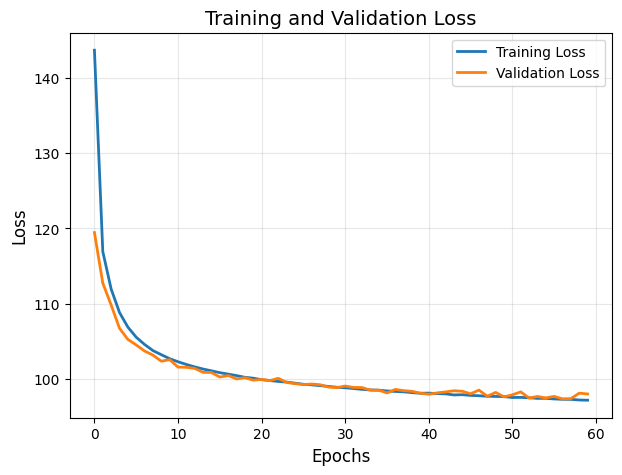

In [149]:
history = {"train_loss": [], "test_loss": []}

for epoch in range(1, epochs + 1):
    train(epoch, history)
    test(epoch, history)
    with torch.no_grad():
        c = torch.eye(10, device=device)
        sample = torch.randn(10, latent_size).to(device)
        sample = model.decode(sample, c).cpu()
        save_image(sample.view(10, 1, 28, 28),
                   'samples/sample_' + str(f"{epoch:02}") + '.png')
        
# Depois do treinamento completo
generate_grid(model, latent_size, device, filename="final_grid.png")

plot_training_history(history)